In [2]:
%load_ext autoreload
%autoreload 2

from ETL import *
from yahist import Hist1D

from yahist.fit import fit_hist
from yahist.utils import ignore_division_errors
import scipy
import os
import mplhep as hep
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import style
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
style.use('seaborn-white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# def plots(sensor_gap_x_list):

#     colors = ['red','blue','green','magneta','yellow','black','maroon','wheat']
#     r_inner = 315
#     r_outer = 1185

#     module_gap = 0.5

#     edge_x = 6  # 6mm is the default

#     z_ref = 2.99825
#     z = [
#         2.99825,
#         3.0055,
#         3.02075,
#         3.0285,
#     ]

#     eta_max = 2.950
#     eta_min = 1.659
#     eta_range = eta_max-eta_min

#     nEvents = int(1e5)

#     eta = np.random.rand(nEvents)*eta_range + eta_min
#     phi = np.random.rand(nEvents)*np.pi - np.pi/2

#     vec = three_vector.fromEtaPhi(eta, phi, np.ones(nEvents)*z_ref*1000)

#     vec_list = []
#     for x,y in zip(vec.x, vec.y):
#         vec_list.append(three_vector(x,y,z_ref*1000))

#     bins = "40,1.659,2.950"
#     den = Hist1D([v.eta for v in vec_list], bins=bins)
#     plt.style.use(hep.style.CMS)  # or ATLAS/LHCb

    
#     hists = []

#     for i in range(len(sensor_gap_x_list)):
    
#         sensor_x = 21.75
#         sensor_y = 22
#         sensor_gap_x = sensor_gap_x_list[i]
#         sensor_gap_y = 0.5
#         module_x = 0.6 + 2*sensor_x + sensor_gap_x
#         module_y = 56.50

#         s = Sensor(sensor_x, sensor_y, deadspace=0.5)

#         m = Module(module_x, module_y,
#                 n_sensor_x = 2,
#                 n_sensor_y = 2,
#                 sensor_distance_y = sensor_y + sensor_gap_y,
#                 sensor_distance_x=sensor_x+sensor_gap_x
#                 )

#         # populate the module with sensors
#         m.populate(s)

#         # create some readout and power boards.
#         # The x dimension will be aligned later on, so we just use a dummy value of 10mm.

#         rb = ReadoutBoard(10, module_y, color='green')
#         pb = ReadoutBoard(10,29.5, color='red')

#         detector = {}

#         SM = SuperModule(m, pb, rb, n_modules=3, module_gap=module_gap, orientation='above')

#         detector['disk1_front'] = Dee(r_inner, r_outer)
#         detector['disk1_front'].populate(SM, edge_x=edge_x, center_RB=True)

#         SM = SuperModule(m, pb, rb, n_modules=3, module_gap=module_gap, orientation='above')

#         detector['disk1_back'] = Dee(315, 1185)
#         detector['disk1_back'].populate(SM, edge_x=edge_x, center_PB=True)

#         SM = SuperModule(m, pb, rb, n_modules=3, module_gap=module_gap, orientation='below')

#         detector['disk2_front'] = Dee(315, 1185)
#         detector['disk2_front'].populate(SM, edge_x=edge_x, center_RB=True)

#         SM = SuperModule(m, pb, rb, n_modules=3, module_gap=module_gap, orientation='below')

#         detector['disk2_back'] = Dee(315, 1185)
#         detector['disk2_back'].populate(SM, edge_x=edge_x, center_PB=True)

#         hits = {
#             'baseline':[],
    
#        }
   
#         nHits = {
#             'baseline':[],
#         }

#         detector_variants = {
#             'baseline': detector,
#             #'remove_face': detector_remove,
#             }

#         layers = ['disk1_front', 'disk1_back', 'disk2_front', 'disk2_back']

#         for v in vec_list:    
#             for det in detector_variants:
#                 n = 0
#                 iLayer = 0
#                 nModules = 0

#                 for layer in layers:
#                     x_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.cos(v.phi)
#                     y_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.sin(v.phi)
#                     x,y = ((v.x + x_shift), (v.y + y_shift))
                        
#                     if detector_variants[det][layer].intersect(x, y):
#                         n += 1
#                     iLayer += 1
                    
#                     nModules += sum( [ sum([ x for x in row if x==1]) for row in detector_variants[det][layer].module_matrix ])
                    
#                 if n>0: hits[det].append(v)
#                 nHits[det].append(n)

#         num = Hist1D([v.eta for v in hits['baseline']], bins=bins)

#         hists.append(num.divide(den, binomial=True))
    
#     fig, ax = plt.subplots(1,1,figsize=(10,10))

#     for i in range(len(hists)):
#         hists[i].plot(show_errors=True, color=colors[i], label=f'sens dis {sensor_gap_x_list[i]}',alpha=0.5)

#     ax.set_ylabel('Efficiency')
#     ax.set_xlabel(r'$\eta$')

#     ax.set_ylim(0.85,1.05)

#     fig.text(0.0, 0.995, '$\\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

#     name = 'efficiency_examples_1'

#     fig.savefig(os.path.join("{}.png".format(name)))



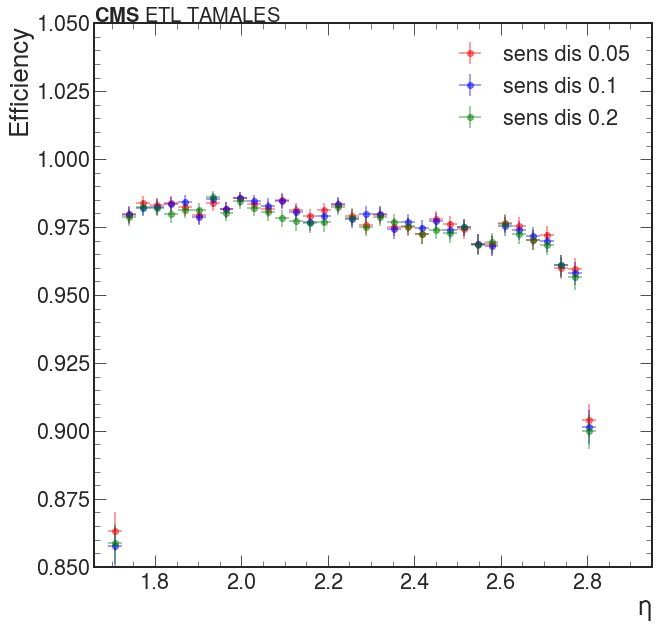

In [9]:
plots([0.05,0.1,0.2])

In [5]:
with open('layouts/database_new.yaml') as f:
    database_new = load(f, Loader=Loader)

disk_new = database_new['new'] 

layers = [['disk1','front'],['disk1','back'],['disk2','front'],['disk2','back']]

class three_vector:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.r     = np.sqrt(x**2+y**2)
        self.theta = np.arctan2(self.r, z)
        self.eta   = -np.log(np.tan(self.theta/2))
        self.phi   = np.arctan2(y, x)
        
    @classmethod
    def fromEtaPhi(cls, eta, phi, z):
        cls.eta = eta
        cls.phi = phi
        cls.z = z
        cls.theta = 2*np.arctan(np.exp(cls.eta*(-1)))
        cls.r = z*np.tan(cls.theta)
        cls.x = cls.r*np.cos(cls.phi)
        cls.y = cls.r*np.sin(cls.phi)
        
        return cls

def get_sign(n1):

    return n1/(np.sqrt(n1*n1))

def fill(layers):
    global disk_new
    for disk, side in layers:
        disk_new[disk][side].sort(key=lambda x:x[1], reverse=True)

        y_s = {}

        for i in disk_new[disk][side]:
            if i[1] in y_s:
                y_s[i[1]].append(i[0])
            else:
                y_s[i[1]] = [i[0]]
            
            y_s[i[1]].sort()


        new_sensors = []

        for y in y_s:
            x_s = y_s[y]
            for i in range(len(x_s)-1):
                if get_sign(x_s[i]) == get_sign(x_s[i+1]):
                    if x_s[i+1]-x_s[i] - 43.6 > 1:
                        n_sensors = int((x_s[i+1]-x_s[i]-43.6)/43.6)
                        s = 43.6
                        for j in range(n_sensors):
                            new_sensors.append((x_s[i]+s,y))
                            s += 43.6
                

        disk_new[disk][side] += new_sensors

z_ref = 2.99825
z = [
    2.99825,
    3.0055,
    3.02075,
    3.0285,
]

import random

eta_max = 2.950
eta_min = 1.659
eta_range = eta_max-eta_min

nEvents = int(1e5)

eta = np.random.rand(nEvents)*eta_range + eta_min
phi = np.random.rand(nEvents)*2*np.pi - np.pi

vec = three_vector.fromEtaPhi(eta, phi, np.ones(nEvents)*3000)

vec_list = []
for x,y in zip(vec.x, vec.y):
    vec_list.append(three_vector(x,y,3000))

delta_z = 20.5 # approximated distance between similar layers (e.g. front disk1 - front disk 2)
colors = ['red','blue','green','magneta','yellow','black','maroon','wheat']
plt.style.use(hep.style.CMS)  # or ATLAS/LHCb
bins_1 = "50,300,1200"
bins_2 ="40,-%s,%s"%(np.pi,np.pi)
bins_3 = "40,1.659,2.950"

den1 = Hist1D([v.r for v in vec_list], bins=bins_1)
den2 = Hist1D([v.phi for v in vec_list], bins=bins_2)
den3 = Hist1D([v.eta for v in vec_list], bins=bins_3)

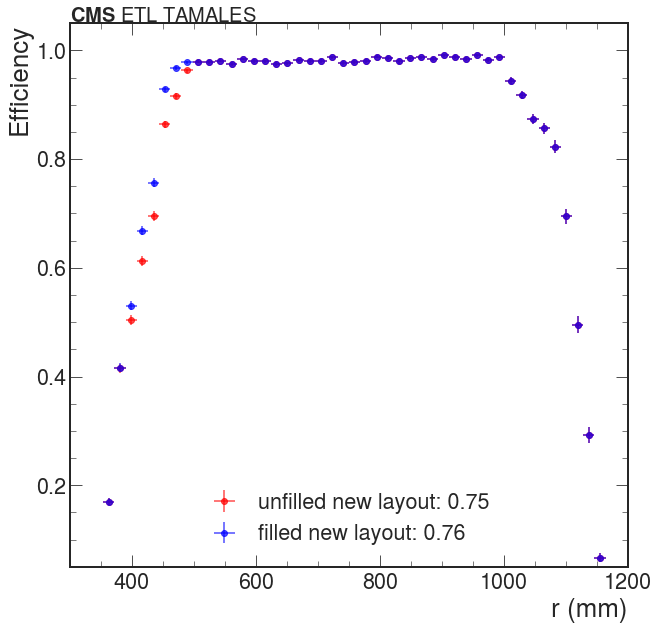

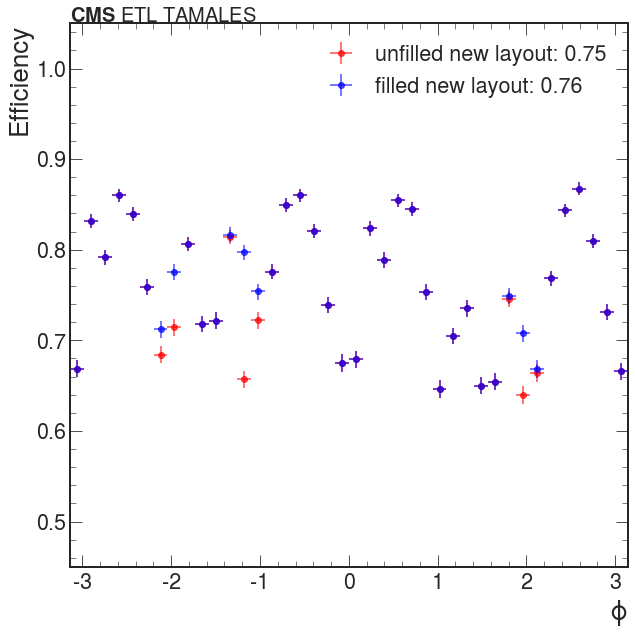

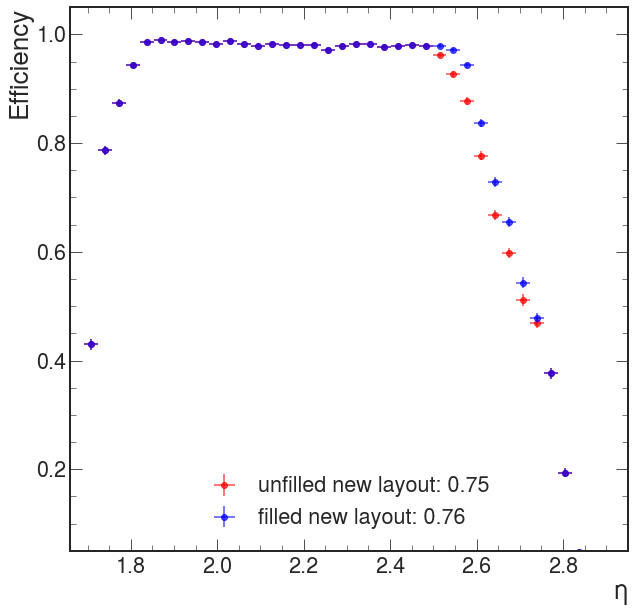

In [6]:
hists_1 = []
hists_2 = []
hists_3 = []

for i in range(2):

    if i == 1:
        fill(layers)

    new_layout = {}

    s = Sensor(42.5, 22)

    new_layout['D1'] = Dee(315, 1185)
    new_layout['D1'].fromCenters(disk_new['disk1']['front'], s)

    new_layout['D2'] = Dee(315, 1185)
    new_layout['D2'].fromCenters(disk_new['disk1']['back'], s)

    new_layout['D3'] = Dee(315, 1185)
    new_layout['D3'].fromCenters(disk_new['disk2']['front'], s)

    new_layout['D4'] = Dee(315, 1185)
    new_layout['D4'].fromCenters(disk_new['disk2']['back'], s)

    hits = {
        # 'TDR':[],
        # 'large_sensor':[],
        # #'large_sensor_v1':[], # with shift
        # 'small_sensor':[],
        # #'small_sensor_v1':[], # with shift
        # #'small_sensor_v2':[],
        # #'small_sensor_v3':[], # with shift
        'new_layout': [],
        }
    
    nHits = {
        # 'TDR':[],
        # 'large_sensor':[],
        # #'large_sensor_v1':[], # with shift
        # 'small_sensor':[],
        # #'small_sensor_v1':[], # with shift
        # #'small_sensor_v2':[],
        # #'small_sensor_v3':[], # with shift
        'new_layout': [],
    }

    detector_variants = {
        
        # 'large_sensor': large_sensor,
        # #'large_sensor_v1': large_sensor_v1,
        # 'small_sensor': small_sensor,
        # #'small_sensor_v1': small_sensor_v1,
        # #'small_sensor_v2': small_sensor_v2,
        # #'small_sensor_v3': small_sensor_v3,
        # 'TDR': TDR,
        'new_layout': new_layout,
            }



    # We also want to get the number of hits.
    for v in vec_list:
        
        
        
        for det in detector_variants:
            n = 0
            iLayer = 0

            for layer in ['D1', 'D2', 'D3', 'D4']:
                x_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.cos(v.phi)
                y_shift = 1000*(z[iLayer]-z_ref)*np.tan(v.theta)*np.sin(v.phi)
                x,y = ((v.x + x_shift), (v.y + y_shift))
                    
                if detector_variants[det][layer].intersect(x, y):
                    n += 1
                iLayer += 1
                
            if n>0: hits[det].append(v)
            nHits[det].append(n)
    

    if i == 0:
        unfilled_eff = len(hits['new_layout'])/len(vec_list)
    else:
        filled_eff = len(hits['new_layout'])/len(vec_list)
    import os
    import mplhep as hep

    

    # num0 = Hist1D([v.eta for v in hits['TDR']], bins=bins)
    # num1 = Hist1D([v.eta for v in hits['large_sensor']], bins=bins)
    # num2 = Hist1D([v.eta for v in hits['small_sensor']], bins=bins)
    # #num3 = Hist1D([v.eta for v in hits['small_sensor_v2']], bins=bins)


    num1 = Hist1D([v.r for v in hits['new_layout']], bins=bins_1)
    num2 = Hist1D([v.phi for v in hits['new_layout']], bins=bins_2)
    num3 = Hist1D([v.eta for v in hits['new_layout']], bins=bins_3)
    #num4 = Hist1D([v.eta for v in hits['small_sensor_v3']], bins=bins)
    #num5 = Hist1D([v.eta for v in hits['small_sensor_v1']], bins=bins)
    #num6 = Hist1D([v.eta for v in hits['large_sensor_v1']], bins=bins)



    # h0 = num0.divide(den, binomial=True)
    h1 = num1.divide(den1, binomial=True)
    h2 = num2.divide(den2, binomial=True)
    h3 = num3.divide(den3, binomial=True)
    #h4 = num4.divide(den, binomial=True)
    #h5 = num5.divide(den, binomial=True)
    #h6 = num6.divide(den, binomial=True)
    hists_1.append(h1)
    hists_2.append(h2)
    hists_3.append(h3)


    # fig.savefig(os.path.join("{}.pdf".format(name)))
    # fig.savefig(os.path.join("{}.png".format(name)))

fig, ax = plt.subplots(1,1,figsize=(10,10))


for i in range(len(hists_1)):
    if i == 1:
        hists_1[i].plot(show_errors=True,color=colors[i],alpha=0.7,label='filled new layout: %.2f'%(filled_eff))

    else:
        hists_1[i].plot(show_errors=True,color=colors[i],label='unfilled new layout: %.2f'%(unfilled_eff),alpha=0.7)

ax.set_ylabel('Efficiency')
ax.set_xlabel('r (mm)')

ax.set_ylim(0.05,1.05)

fig.text(0.0, 0.995, '$\\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

name = 'efficiency_vs_r'
fig.savefig(os.path.join("{}.png".format(name)))

fig, ax = plt.subplots(1,1,figsize=(10,10))

for i in range(len(hists_2)):
    if i == 1:
        hists_2[i].plot(show_errors=True,color=colors[i],label='filled new layout: %.2f'%(filled_eff),alpha=0.7)

    else:
        hists_2[i].plot(show_errors=True,color=colors[i],label='unfilled new layout: %.2f'%(unfilled_eff),alpha=0.7)


ax.set_ylim(0.45,1.05)

ax.set_ylabel('Efficiency')
ax.set_xlabel(r'$\phi$')

fig.text(0.0, 0.995, r'$\bf{CMS}$ ETL TAMALES', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

name = 'efficiency_vs_phi'
fig.savefig(os.path.join("{}.png".format(name)))

fig, ax = plt.subplots(1,1,figsize=(10,10))

for i in range(len(hists_3)):
    if i == 1:
        hists_3[i].plot(show_errors=True,color=colors[i],label='filled new layout: %.2f'%(filled_eff),alpha=0.7)

    else:
        hists_3[i].plot(show_errors=True,color=colors[i],label='unfilled new layout: %.2f'%(unfilled_eff),alpha=0.7)

ax.set_ylabel('Efficiency')
ax.set_xlabel(r'$\eta$')
ax.set_ylim(0.05,1.05)

name = 'efficiency_vs_eta'

fig.savefig(os.path.join("{}.png".format(name)))

In [7]:
hists

[[ 0.04 ± 0.00    0.42 ± 0.01    0.80 ± 0.01    0.88 ± 0.01    0.95 ± 0.00
   0.99 ± 0.00    0.99 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.99 ± 0.00
   0.99 ± 0.00    0.99 ± 0.00    0.98 ± 0.00    0.99 ± 0.00    0.99 ± 0.00
   0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00
   0.98 ± 0.00    0.97 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00
   0.98 ± 0.00    0.98 ± 0.00    0.96 ± 0.00    0.93 ± 0.01    0.85 ± 0.01
   0.72 ± 0.01    0.67 ± 0.01    0.56 ± 0.01    0.47 ± 0.01    0.36 ± 0.01
   0.18 ± 0.01    0.05 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00],
 [ 0.04 ± 0.00    0.42 ± 0.01    0.80 ± 0.01    0.88 ± 0.01    0.95 ± 0.00
   0.99 ± 0.00    0.99 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.99 ± 0.00
   0.99 ± 0.00    0.99 ± 0.00    0.98 ± 0.00    0.99 ± 0.00    0.99 ± 0.00
   0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00
   0.98 ± 0.00    0.97 ± 0.00    0.98 ± 0.00    0.98 ± 0.00    0.98 ± 0.00
   0.98 ± 0.00    0.98 

In [9]:
len(hists)

2